# Digits recognition by deep learning

In this example, we'll explore learning with Caffe in Python, using the fully-exposed `Solver` interface.
The code is based on https://github.com/BVLC/caffe/tree/master/examples

In [1]:
import caffe
import lmdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll be running the provided LeNet example (make sure you've downloaded the data and created the databases, as below).

We need two external files to help out:
* the net prototxt, defining the architecture and pointing to the train/test data
* the solver prototxt, defining the learning parameters

We start with the net. We'll write the net in a succinct and natural way as Python code that serializes to Caffe's protobuf model format.

This network expects to read from pregenerated LMDBs, but reading directly from `ndarray`s is also possible using `MemoryDataLayer`.

### Split train into validation and, well, train

In [2]:
! rm -rf train_train_lmdb/ validation_lmdb/

In [3]:
env_input = lmdb.open("train_lmdb")
train_count = 50000
test_count = 10000
page_size = 798*4
env_train_train = lmdb.open("train_train_lmdb", map_size=page_size*train_count)
env_validation = lmdb.open("validation_lmdb", map_size=page_size*test_count)
datum = caffe.proto.caffe_pb2.Datum()
with env_input.begin(write=False) as txn:
    cursor = txn.cursor()
    with env_train_train.begin(write=True) as txn_train_train:
        with env_validation.begin(write=True) as txn_validation:
            for key, value in cursor:
                item = datum.FromString(value)
                if int(key) < train_count:
                    txn_train_train.put(key, value)
                else:
                    txn_validation.put(key, value)            
env_input.close()
env_train_train.close()
env_validation.close()

In [41]:
from caffe import layers as L
from caffe import params as P

def lenet(lmdb, batch_size):
    # a version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    # convolutional layer
    # n.data - input blob
    # kernel_size - height and width of each filter
    # stride - pecifies the number of pixels to (implicitly) add to each side of the input
    # num_output - the number of filters
    # weight_filler - initial weights distribution, see
    # for explanation http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # SELF Try adding another convolutional & pool layers
    # Note the speed drop - think whether you can afford it
    # n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    # n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX) 
    n.ip1 = L.InnerProduct(n.pool1, num_output=500, weight_filler=dict(type='xavier'))
    # SLEF Try enabling ReLU, see whether the quality increases
    # n.relu1 = L.ReLU(n.ip1, in_place=True)
    # SELF Try adding a dropout layer, see whether the quality increases
    # n.drop1 = L.Dropout(n.ip1, dropout_ratio=0.5, in_place=True)
    n.ip2 = L.InnerProduct(n.ip1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss = L.SoftmaxWithLoss(n.ip2, n.label)
    return n.to_proto()
    # You can look for more inspiration here: https://gist.github.com/ksimonyan/fd8800eeb36e276cd6f9
    # And detailed descriptions http://caffe.berkeleyvision.org/tutorial/layers.html

We write two network configurations: for training and validation. When preparing the submission, we'll, of course, use the whole training dataset.

In [5]:
with open('lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('train_train_lmdb', 64)))
    
validation_batch_size = 100
with open('lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('validation_lmdb', validation_batch_size)))

In [6]:
# caffe.draw.draw fails with a syntax error
import pydot
import caffe.draw
def draw_net(net):
    class FixedDot(pydot.Dot):
        graph = caffe.draw.get_pydot_graph(net, "LR", True)
        with open("graph.dot", "w") as dot_file:
            dot_file.write("digraph " + graph.to_string())

In [7]:
draw_net(lenet('validation_lmdb', validation_batch_size))

In [8]:
! dot -Tsvg graph.dot > graph.svg

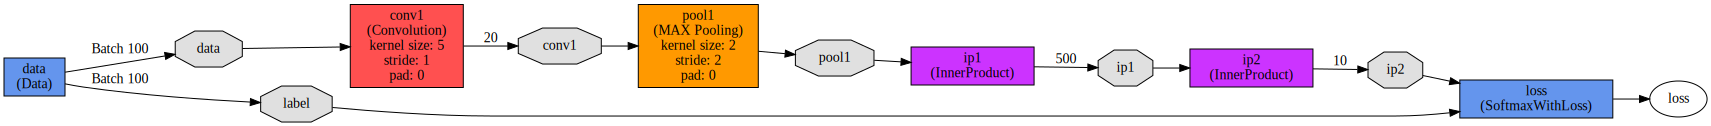

In [9]:
from IPython.display import SVG
SVG("graph.svg")

The net has been written to disk in more verbose but human-readable serialization format using Google's protobuf library. You can read, write, and modify this description directly. Let's take a look at the train net.

Now let's see the learning parameters, which are also written as a `prototxt` file. We're using SGD with momentum, weight decay, and a specific learning rate schedule.

In [10]:
!cat lenet_auto_solver.prototxt

# The train/test net protocol buffer definition
train_net: "lenet_auto_train.prototxt"
test_net: "lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "lenet_snapshot"


Let's pick a device and load the solver. We'll use SGD (with momentum), but Adagrad and Nesterov's accelerated gradient are also available.

In [11]:
prototxt_solver = "lenet_auto_solver.prototxt"

In [12]:
solver = caffe.SGDSolver(prototxt_solver)

To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [13]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('ip1', (64, 500)),
 ('ip2', (64, 10)),
 ('loss', ())]

In [14]:
# just print the weight sizes (not biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)), ('ip1', (500, 2880)), ('ip2', (10, 500))]

Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [15]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.2922797203063965, dtype=float32)}

In [16]:
def show_nice_image(image, size):
    fig, ax = plt.subplots(figsize=size)
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    return fig

[ 2.  7.  7.  5.  8.  3.  6.  7.]


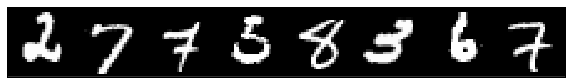

In [17]:
# we use a little trick to tile the first eight images
show_nice_image(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), (10, 3))
print solver.net.blobs['label'].data[:8]

[ 9.  6.  9.  4.  0.  7.  0.  1.]


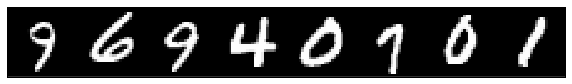

In [18]:
show_nice_image(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), (10, 3))
print solver.test_nets[0].blobs['label'].data[:8]

Both train and test nets seem to be loading data, and to have correct labels.

Let's take one step of (minibatch) SGD and see what happens.

In [19]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

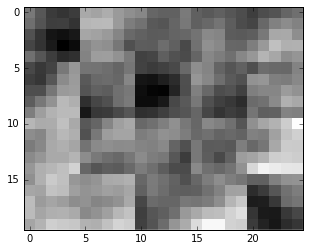

In [20]:
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray', interpolation='none')

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

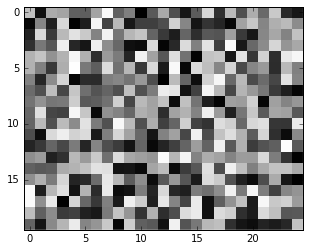

In [21]:
fig, ax = plt.subplots(figsize=(15, 20))
ax.imshow(solver.net.blobs['conv1'].data
          .transpose(0, 2, 1, 3).reshape(64*20, 24*24)[:400, :], cmap='gray', interpolation='none')

In [22]:
niter = 200
test_interval = 25
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 8, 10))

In [23]:
%%time
# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['ip2'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['ip2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
CPU times: user 1min 42s, sys: 1min 52s, total: 3min 34s
Wall time: 1min 4s


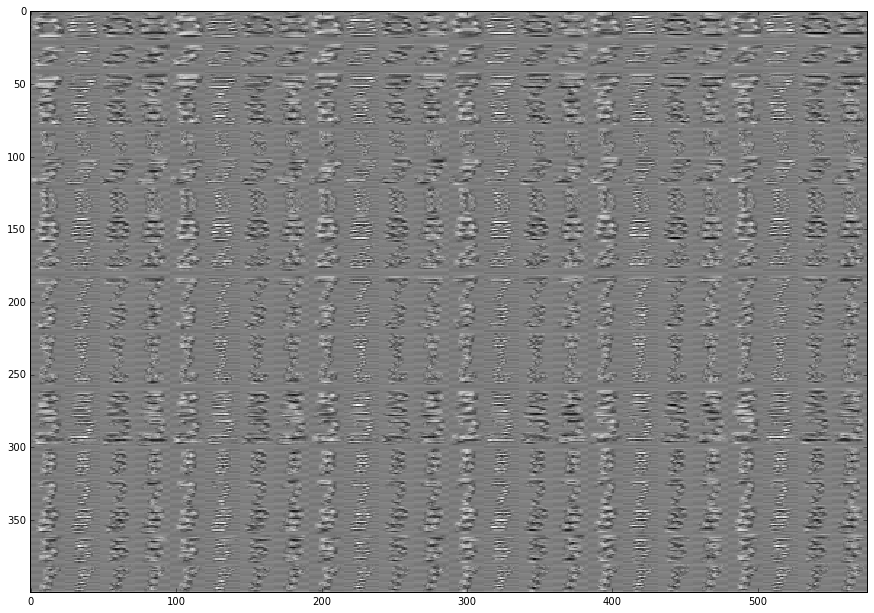

In [24]:
fig, ax = plt.subplots(figsize=(15, 20))
ax.imshow(solver.net.blobs['conv1'].data
          .transpose(0, 2, 1, 3).reshape(64*20, 24*24)[:400, :], cmap='gray', interpolation='none')

Let's plot the train loss and test accuracy.

0.9133


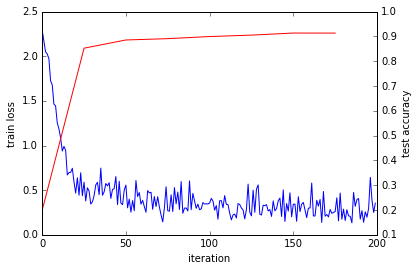

In [25]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
print(test_acc[-1])

The loss seems to have dropped quickly and coverged (except for stochasticity), while the accuracy rose correspondingly. Hooray!

Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

In [26]:
def show_nice_evolution(image, size):
    fig, ax = plt.subplots(figsize=size)
    ax.imshow(image, cmap='gray', interpolation='none')
    ax.set_yticks(range(10))
    ax.set_xlabel('iteration')
    ax.set_ylabel('label')
    return fig

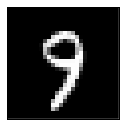

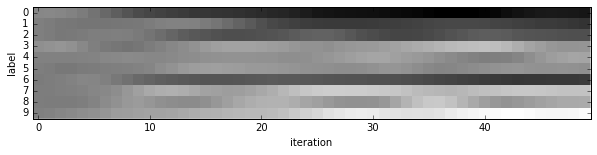

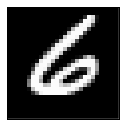

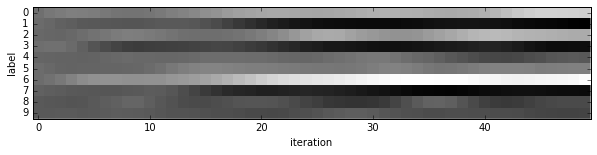

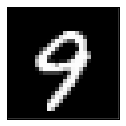

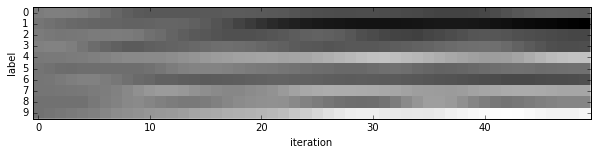

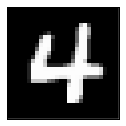

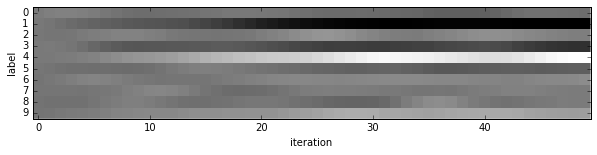

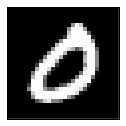

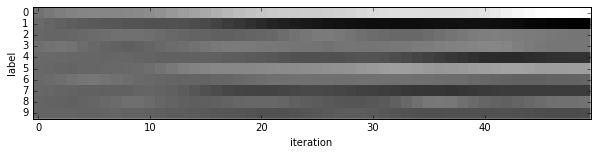

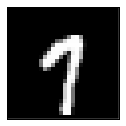

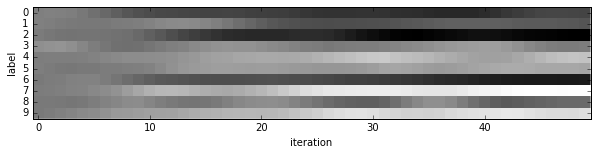

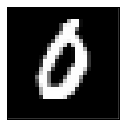

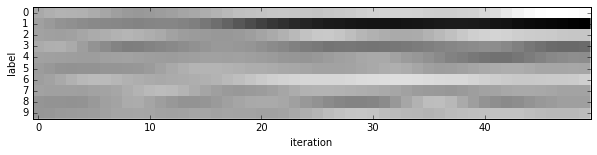

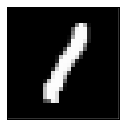

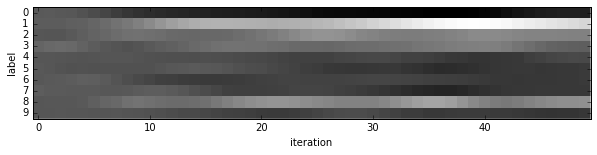

In [27]:
for i in range(8):
    show_nice_image(solver.test_nets[0].blobs['data'].data[i, 0], (2,2))
    show_nice_evolution(output[:50, i].T, (10, 2))

We started with little idea about any of these digits, and ended up with correct classifications for each.

Note that these are the "raw" output scores rather than the softmax-computed probability vectors. The latter, shown below, make it easier to see the confidence of our net (but harder to see the scores for less likely digits).

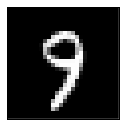

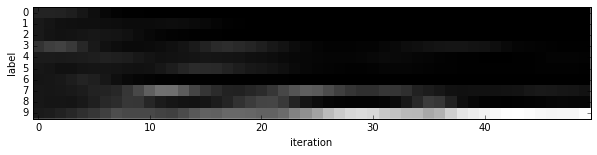

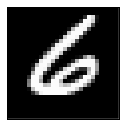

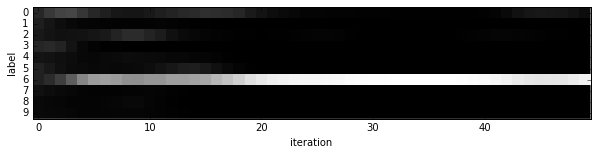

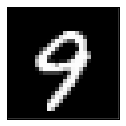

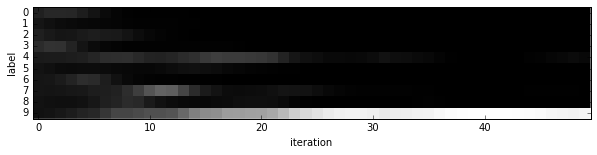

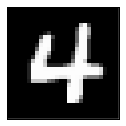

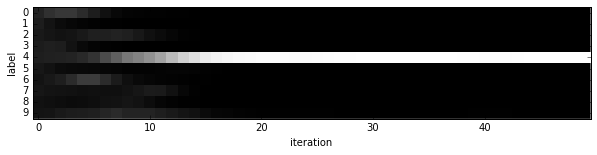

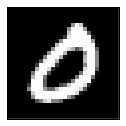

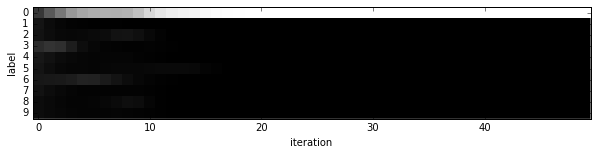

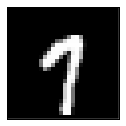

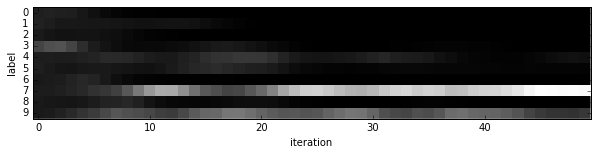

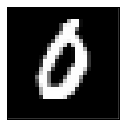

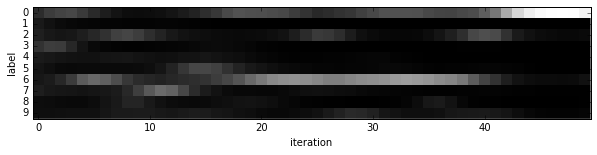

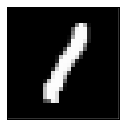

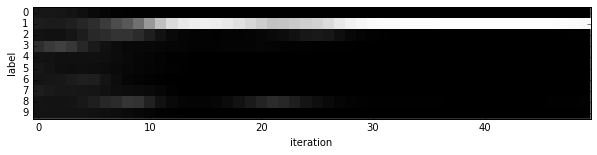

In [28]:
for i in range(8):
    show_nice_image(solver.test_nets[0].blobs['data'].data[i, 0], (2, 2))
    show_nice_evolution(np.exp(output[:50, i].T) / np.exp(output[:50, i].T).sum(0), (10, 2))

## OK, here we prepare a submission for the competition

In [29]:
with open('lenet_full_train.prototxt', 'w') as f:
    f.write(str(lenet('train_lmdb', 64)))

In [30]:
kaggle_test_batch_size = 100
kaggle_test_size = 10000
if kaggle_test_size % kaggle_test_batch_size != 0:
    raise ValueError("Please make kaggle_test_batch_size a divisor of kaggle_test_size")
kaggle_iterations = kaggle_test_size / kaggle_test_batch_size
with open('lenet_kaggle_test.prototxt', 'w') as f:
    f.write(str(lenet('test_lmdb', kaggle_test_batch_size)))

In [31]:
solver_parameters = caffe.proto.caffe_pb2.SolverParameter()
f = open(prototxt_solver, 'r')
from google.protobuf import text_format
text_format.Merge(str(f.read()), solver_parameters)

In [32]:
solver_parameters.train_net = "lenet_full_train.prototxt"
del solver_parameters.test_net[:]
solver_parameters.test_net.extend(["lenet_kaggle_test.prototxt"])
del solver_parameters.test_iter[:]
solver_parameters.test_iter.extend([kaggle_iterations, ])
final_solver_file_name = "final_solver.prototxt"
with open(final_solver_file_name, 'w') as f:
    f.write(text_format.MessageToString(solver_parameters))    

In [33]:
! cat final_solver.prototxt

train_net: "lenet_full_train.prototxt"
test_net: "lenet_kaggle_test.prototxt"
test_iter: 100
test_interval: 500
base_lr: 0.01
display: 100
max_iter: 10000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 5000
snapshot_prefix: "lenet_snapshot"


In [34]:
final_solver = caffe.SGDSolver(final_solver_file_name)
final_solver.step(niter)

In [35]:
labels = np.array([])
for iteration in xrange(kaggle_iterations):
    final_solver.test_nets[0].forward()
    labels = np.hstack((labels, final_solver.test_nets[0].blobs['ip2'].data.argmax(1)))

In [36]:
import pandas as pd

In [37]:
pd.DataFrame({"label": labels.astype(np.ubyte)}).to_csv("starterkit.csv", index_label="id")

In [38]:
from IPython.display import FileLink
FileLink("starterkit.csv")

/notebooks/deep_lab/starterkit.csv

Now you can download and submit the prediction to the competition at https://inclass.kaggle.com/c/digits-classification-dubna-2015 